# W281 Final Project: Intel Image Classification Model #

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import gc
import time

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from skimage.feature import hog
from skimage.color import rgb2gray, rgb2hsv


from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# def load_images(directory, num_files=5):
#     images = []
#     file_list = os.listdir(directory)[:num_files]  # Load only the first 5 files

#     for filename in tqdm(file_list, desc=f"Loading images from {directory}"):
#         img_path = os.path.join(directory, filename)
#         img = Image.open(img_path)
#         img = img.resize((150, 150))  # Resize image to 150 x 150
#         images.append(img)

#     return images

In [3]:
# # Image Paths

# buildings_train = './seg_train/buildings'
# forest_train = './seg_train/forest'
# glacier_train = './seg_train/glacier'
# mountain_train = './seg_train/mountain'
# sea_train = './seg_train/sea'
# street_train = './seg_train/street'

# buildings_test = './seg_test/buildings'
# forest_test = './seg_test/forest'
# glacier_test = './seg_test/glacier'
# mountain_test = './seg_test/mountain'
# sea_test = './seg_test/sea'
# street_test = './seg_test/street'

In [4]:
# # Load images from each category
# buildings_img = load_images(buildings_train)
# forest_img = load_images(forest_train)
# glacier_img = load_images(glacier_train)
# mountain_img = load_images(mountain_train)
# sea_img = load_images(sea_train)
# street_img = load_images(street_train)

In [5]:
# buildings_img

## Load Data ##

In [6]:
def load_data(datasets):
    
    output = []

    for dataset in datasets:
        images, labels = [], []
        print(f"Loading {dataset}...")
        i = 0
        for folder in os.listdir(dataset):
            label = i # Converting word labels to int (i.e. buildings = 0)
            i = i+1
            folder_path = os.path.join(dataset, folder)

            for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
                img_path = os.path.join(folder_path, file)

                image = Image.open(img_path).resize((150, 150))
                images.append(image)
                labels.append(label)
                
        images = np.stack(images)
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
        
    return output

In [7]:
# datasets = ["C:\w281\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya/seg_train", 
#         "C:\w281\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya/seg_test"]

datasets = ["C:\\Users\\benzo\\repo\\w281\\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\\seg_train",
            "C:\\Users\\benzo\\repo\\w281\\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\\seg_test"]

# datasets = ["/Users/zdbrown13/w281/w281_Final_Project_Brown_Benzoni_Olaya/seg_train", 
#         "/Users/zdbrown13/w281/w281_Final_Project_Brown_Benzoni_Olaya/seg_test"]

train_path, test_path = datasets

In [8]:


(train_images, train_labels), (test_images, test_labels) = load_data(datasets)


Loading C:\Users\benzo\repo\w281\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_train...


Processing street: 100%|██████████| 2382/2382 [00:01<00:00, 1395.83it/s]


Loading C:\Users\benzo\repo\w281\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_test...


Processing street: 100%|██████████| 501/501 [00:00<00:00, 1451.85it/s]


In [9]:
train_images.shape

(14034, 150, 150, 3)

In [10]:
# Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [11]:
# Training Data Distribution
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2191, 1: 2271, 2: 2404, 3: 2512, 4: 2274, 5: 2382}


In [12]:
avg = sum(counts)/len(unique)
print(avg)

2339.0


In [13]:
# Test Data Distribution
test_unique, test_counts = np.unique(test_labels, return_counts=True)
print(dict(zip(test_unique, test_counts)))

{0: 437, 1: 474, 2: 553, 3: 525, 4: 510, 5: 501}


In [14]:
test_avg = sum(test_counts)/len(test_unique)
print(test_avg)

500.0


# Feature Extraction Methods


In [15]:
# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        img_gray = rgb2gray(img)
        features = hog(img_gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Function to extract HSV histogram features
def extract_hsv_features(images):
    hsv_features = []
    for img in tqdm(images, desc="Extracting HSV features"):
        img_hsv = rgb2hsv(img)
        h_hist, _ = np.histogram(img_hsv[:, :, 0], bins=50, range=(0, 1))
        s_hist, _ = np.histogram(img_hsv[:, :, 1], bins=50, range=(0, 1))
        v_hist, _ = np.histogram(img_hsv[:, :, 2], bins=50, range=(0, 1))
        features = np.concatenate([h_hist, s_hist, v_hist])
        hsv_features.append(features)
    return np.array(hsv_features)

# Function to extract features using ResNet50
def extract_resnet_features(images):
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(150, 150, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    features = model.predict(images, batch_size=32, verbose=1)
    return features

In [16]:
# Prepare a function to process features, apply PCA, and scale
def process_features(train_feat, test_feat, n_components=100):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)

    # Scale features
    train_feat_scaled = scaler.fit_transform(train_feat)
    test_feat_scaled = scaler.transform(test_feat)

    # Apply PCA
    train_feat_pca = pca.fit_transform(train_feat_scaled)
    test_feat_pca = pca.transform(test_feat_scaled)

    return train_feat_pca, test_feat_pca

## Classifier Evaluator 

In [17]:
# Prepare a function to train classifiers and record accuracy and inference time
def evaluate_classifier(X_train, X_test, y_train, y_test, classifier_name, feature_name):
    results = {}

    classifiers = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'SVM': SVC(probability=True)
    }

    clf = classifiers[classifier_name]

    # Measure training time
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Measure inference time
    start_time = time.time()
    y_pred = clf.predict(X_test)
    inference_time = time.time() - start_time

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results['Feature'] = feature_name
    results['Classifier'] = classifier_name
    results['Accuracy'] = accuracy
    results['Train Time'] = train_time
    results['Inference Time'] = inference_time

    print(f"Feature: {feature_name}, Classifier: {classifier_name}, Accuracy: {accuracy:.4f}, "
          f"Train Time: {train_time:.2f}s, Inference Time: {inference_time:.2f}s")

    return results

# Train and test classifiers

In [18]:
# Extract features
print("\n--- Extracting HOG Features ---")
train_hog = extract_hog_features(train_images)
test_hog = extract_hog_features(test_images)

print("\n--- Extracting HSV Features ---")
train_hsv = extract_hsv_features(train_images)
test_hsv = extract_hsv_features(test_images)

print("\n--- Extracting ResNet Features ---")
train_resnet = extract_resnet_features(train_images)
test_resnet = extract_resnet_features(test_images)

# Reduce dataset size if necessary (optional)
# To reduce computation time, you can sample a subset of data
# For example, use 2000 samples
sample_size = 2000
train_indices = np.random.choice(len(train_hog), sample_size, replace=False)
test_indices = np.random.choice(len(test_hog), int(sample_size * 0.2), replace=False)

train_hog_sample = train_hog[train_indices]
test_hog_sample = test_hog[test_indices]
train_hsv_sample = train_hsv[train_indices]
test_hsv_sample = test_hsv[test_indices]
train_resnet_sample = train_resnet[train_indices]
test_resnet_sample = test_resnet[test_indices]
train_labels_sample = train_labels[train_indices]
test_labels_sample = test_labels[test_indices]

# Process features: apply PCA and scaling
print("\n--- Processing HOG Features ---")
train_hog_pca, test_hog_pca = process_features(train_hog_sample, test_hog_sample, n_components=100)

print("\n--- Processing HSV Features ---")
train_hsv_pca, test_hsv_pca = process_features(train_hsv_sample, test_hsv_sample, n_components=50)

print("\n--- Processing ResNet Features ---")
# ResNet features are already of lower dimension, you may skip PCA or apply minimal reduction
train_resnet_pca, test_resnet_pca = process_features(train_resnet_sample, test_resnet_sample, n_components=128)

# Prepare label encodings
y_train = train_labels_sample
y_test = test_labels_sample



--- Extracting HOG Features ---


Extracting HOG features: 100%|██████████| 3000/3000 [00:23<00:00, 128.37it/s]



--- Extracting HSV Features ---


Extracting HSV features: 100%|██████████| 3000/3000 [00:13<00:00, 224.95it/s]



--- Extracting ResNet Features ---
439/439 ━━━━━━━━━━━━━━━━━━━━ 199s 450ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step

--- Processing HOG Features ---

--- Processing HSV Features ---

--- Processing ResNet Features ---


In [19]:
# Initialize results DataFrame
results_df = pd.DataFrame(columns=['Feature', 'Classifier', 'Accuracy', 'Train Time', 'Inference Time'])

# Evaluate classifiers on HOG features
print("\n--- Evaluating on HOG Features ---")
for clf_name in ['LogisticRegression', 'SVM']:
    result = evaluate_classifier(train_hog_pca, test_hog_pca, y_train, y_test, clf_name, 'HOG')
    results_df = results_df.append(result, ignore_index=True)

# Evaluate classifiers on HSV features
print("\n--- Evaluating on HSV Features ---")
for clf_name in ['LogisticRegression', 'SVM']:
    result = evaluate_classifier(train_hsv_pca, test_hsv_pca, y_train, y_test, clf_name, 'HSV')
    results_df = results_df.append(result, ignore_index=True)

# Evaluate classifiers on ResNet features
print("\n--- Evaluating on ResNet Features ---")
for clf_name in ['LogisticRegression', 'SVM']:
    result = evaluate_classifier(train_resnet_pca, test_resnet_pca, y_train, y_test, clf_name, 'ResNet')
    results_df = results_df.append(result, ignore_index=True)

# Display the results
print("\n--- Summary of Results ---")
print(results_df)

# Identify the best performing and fastest configurations
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
fastest_inference = results_df.loc[results_df['Inference Time'].idxmin()]

print("\nBest Performing Configuration:")
print(best_accuracy)

print("\nFastest Inference Configuration:")
print(fastest_inference)


--- Evaluating on HOG Features ---
Feature: HOG, Classifier: LogisticRegression, Accuracy: 0.6525, Train Time: 0.68s, Inference Time: 0.00s


C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\1669950379.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


Feature: HOG, Classifier: SVM, Accuracy: 0.7175, Train Time: 1.15s, Inference Time: 0.09s

--- Evaluating on HSV Features ---
Feature: HSV, Classifier: LogisticRegression, Accuracy: 0.4775, Train Time: 0.06s, Inference Time: 0.00s


C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\1669950379.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)
C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\1669950379.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


Feature: HSV, Classifier: SVM, Accuracy: 0.5150, Train Time: 1.28s, Inference Time: 0.09s

--- Evaluating on ResNet Features ---


C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\1669950379.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


Feature: ResNet, Classifier: LogisticRegression, Accuracy: 0.6775, Train Time: 0.47s, Inference Time: 0.00s


C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\1669950379.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


Feature: ResNet, Classifier: SVM, Accuracy: 0.6350, Train Time: 1.23s, Inference Time: 0.11s

--- Summary of Results ---
  Feature          Classifier  Accuracy  Train Time  Inference Time
0     HOG  LogisticRegression    0.6525    0.675167        0.000000
1     HOG                 SVM    0.7175    1.145964        0.094747
2     HSV  LogisticRegression    0.4775    0.059840        0.000997
3     HSV                 SVM    0.5150    1.277612        0.088735
4  ResNet  LogisticRegression    0.6775    0.466722        0.000998
5  ResNet                 SVM    0.6350    1.231723        0.108722

Best Performing Configuration:
Feature                HOG
Classifier             SVM
Accuracy            0.7175
Train Time        1.145964
Inference Time    0.094747
Name: 1, dtype: object

Fastest Inference Configuration:
Feature                          HOG
Classifier        LogisticRegression
Accuracy                      0.6525
Train Time                  0.675167
Inference Time                 

C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\1669950379.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


In [20]:
# Combine Features into a Single Matrix
def combine_features(hog_features, hsv_features, resnet_features):
    return np.hstack((hog_features, hsv_features, resnet_features))

# Extract Features (as done earlier)
print("\n--- Extracting Features ---")
train_hog = extract_hog_features(train_images)
test_hog = extract_hog_features(test_images)

train_hsv = extract_hsv_features(train_images)
test_hsv = extract_hsv_features(test_images)

train_resnet = extract_resnet_features(train_images)
test_resnet = extract_resnet_features(test_images)

# Optional: Apply PCA to reduce dimensions of each feature set
train_hog_pca, test_hog_pca = process_features(train_hog, test_hog, n_components=100)
train_hsv_pca, test_hsv_pca = process_features(train_hsv, test_hsv, n_components=50)
train_resnet_pca, test_resnet_pca = process_features(train_resnet, test_resnet, n_components=128)

# Combine Features
print("\n--- Combining Features ---")
train_combined = combine_features(train_hog_pca, train_hsv_pca, train_resnet_pca)
test_combined = combine_features(test_hog_pca, test_hsv_pca, test_resnet_pca)

print(f"Combined Feature Shape (Train): {train_combined.shape}")
print(f"Combined Feature Shape (Test): {test_combined.shape}")

# Train Classifiers on Combined Features
print("\n--- Training Classifiers on Combined Features ---")
results_df = pd.DataFrame(columns=['Feature', 'Classifier', 'Accuracy', 'Train Time', 'Inference Time'])

for clf_name in ['LogisticRegression', 'SVM']:
    result = evaluate_classifier(train_combined, test_combined, train_labels, test_labels, clf_name, 'Combined')
    results_df = results_df.append(result, ignore_index=True)

# Display Results
print("\n--- Summary of Results for Combined Features ---")
print(results_df)

# Identify the Best and Fastest Configurations
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
fastest_inference = results_df.loc[results_df['Inference Time'].idxmin()]

print("\nBest Performing Configuration:")
print(best_accuracy)

print("\nFastest Inference Configuration:")
print(fastest_inference)



--- Extracting Features ---


Extracting HSV features: 100%|██████████| 3000/3000 [00:14<00:00, 202.49it/s]


439/439 ━━━━━━━━━━━━━━━━━━━━ 225s 507ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 46s 469ms/step

--- Combining Features ---
Combined Feature Shape (Train): (14034, 278)
Combined Feature Shape (Test): (3000, 278)

--- Training Classifiers on Combined Features ---


C:\Users\benzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\633699021.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


Feature: Combined, Classifier: LogisticRegression, Accuracy: 0.7847, Train Time: 9.56s, Inference Time: 0.00s
Feature: Combined, Classifier: SVM, Accuracy: 0.8173, Train Time: 86.71s, Inference Time: 7.80s

--- Summary of Results for Combined Features ---
    Feature          Classifier  Accuracy  Train Time  Inference Time
0  Combined  LogisticRegression  0.784667    9.564425        0.002992
1  Combined                 SVM  0.817333   86.709176        7.802112

Best Performing Configuration:
Feature            Combined
Classifier              SVM
Accuracy           0.817333
Train Time        86.709176
Inference Time     7.802112
Name: 1, dtype: object

Fastest Inference Configuration:
Feature                     Combined
Classifier        LogisticRegression
Accuracy                    0.784667
Train Time                  9.564425
Inference Time              0.002992
Name: 0, dtype: object


C:\Users\benzo\AppData\Local\Temp\ipykernel_5140\633699021.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result, ignore_index=True)


## PCA & SVM

In [21]:
# Flatten the data for Random Forest & SVM
X_train_flat = train_images.reshape(len(train_images), -1)
X_test_flat = test_images.reshape(len(test_images), -1)
y_train_trad = train_labels
y_test_trad = test_labels

# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    X_train_flat,
    y_train_trad,
    test_size=0.2,
    random_state=42
)

In [22]:
y_train_trad.shape

(14034,)

In [23]:
y_train_ml.shape

(11227,)

In [24]:
gc.collect()

127190

In [25]:
# Define batch size
batch_size = 500
n_samples, n_features = X_train_ml.shape

# First pass: Compute mean and variance for StandardScaler
mean_sum = np.zeros(n_features, dtype=np.float32)
var_sum = np.zeros(n_features, dtype=np.float32)
n_total = 0

print("Computing mean and variance in batches...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Update mean and variance sums
    mean_sum += np.sum(batch, axis=0)
    var_sum += np.sum(np.square(batch), axis=0)
    n_total += batch.shape[0]
    
    if i % 2000 == 0:
        print(f"Processed {i}/{n_samples} samples")

# Calculate final mean and variance
mean = mean_sum / n_total
variance = (var_sum / n_total) - np.square(mean)
scale = np.sqrt(variance)

Computing mean and variance in batches...
Processed 0/11227 samples
Processed 2000/11227 samples
Processed 4000/11227 samples
Processed 6000/11227 samples
Processed 8000/11227 samples
Processed 10000/11227 samples


In [26]:
# Initialize IPCA
print("Performing incremental PCA...")
n_components = 500
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    current_batch_size = end - i
    
    # Scale the batch manually
    batch_scaled = (batch - mean) / scale
    
    # Only try to fit if batch is large enough
    if current_batch_size >= n_components:
        ipca.partial_fit(batch_scaled)
        if i % 2000 == 0:
            print(f"Fitted PCA on {i}/{n_samples} samples")
    else:
        print(f"Skipping final incomplete batch of size {current_batch_size} (smaller than n_components={n_components})")

print("IPCA fitting complete!")

Performing incremental PCA...
Fitted PCA on 0/11227 samples
Fitted PCA on 2000/11227 samples
Fitted PCA on 4000/11227 samples
Fitted PCA on 6000/11227 samples
Fitted PCA on 8000/11227 samples
Fitted PCA on 10000/11227 samples
Skipping final incomplete batch of size 227 (smaller than n_components=500)
IPCA fitting complete!


In [27]:
# Third pass: Transform data in batches and train classifier
X_train_transformed = np.zeros((n_samples, n_components), dtype=np.float32)

print("Transforming data...")
for i in range(0, n_samples, batch_size):
    end = min(i + batch_size, n_samples)
    batch = X_train_ml[i:end].astype(np.float32)
    
    # Scale and transform batch
    batch_scaled = (batch - mean) / scale
    X_train_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_samples} samples")

print("Final reduced data shape:", X_train_transformed.shape)

Transforming data...
Transformed 0/11227 samples
Transformed 2000/11227 samples
Transformed 4000/11227 samples
Transformed 6000/11227 samples
Transformed 8000/11227 samples
Transformed 10000/11227 samples
Final reduced data shape: (11227, 500)


In [28]:
# Free memory
del X_train_flat
gc.collect()

0

In [29]:
# Transform Validation Data
print("Transforming validation data...")
n_val_samples = X_val_ml.shape[0]
X_val_transformed = np.zeros((n_val_samples, n_components), dtype=np.float32)

for i in range(0, n_val_samples, batch_size):
    end = min(i + batch_size, n_val_samples)
    batch = X_val_ml[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_val_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_val_samples} validation samples")

print("Validation data transformation complete!")
print("Validation data reduced shape:", X_val_transformed.shape)

Transforming validation data...
Transformed 0/2807 validation samples
Transformed 2000/2807 validation samples
Validation data transformation complete!
Validation data reduced shape: (2807, 500)


In [30]:
# Transform Test Data
print("Transforming test data...")
n_test_samples = X_test_flat.shape[0]
X_test_transformed = np.zeros((n_test_samples, n_components), dtype=np.float32)

for i in range(0, n_test_samples, batch_size):
    end = min(i + batch_size, n_test_samples)
    batch = X_test_flat[i:end].astype(np.float32)
    
    # Scale and transform batch using already computed mean/scale
    batch_scaled = (batch - mean) / scale
    X_test_transformed[i:end] = ipca.transform(batch_scaled)
    
    if i % 2000 == 0:
        print(f"Transformed {i}/{n_test_samples} test samples")

print("Test data transformation complete!")
print("Test data reduced shape:", X_test_transformed.shape)

Transforming test data...
Transformed 0/3000 test samples
Transformed 2000/3000 test samples
Test data transformation complete!
Test data reduced shape: (3000, 500)


In [31]:
# Now we will standardize all 3 data sets

scaler = StandardScaler()

# Fit scaler on training data
X_train_transformed_scaled = scaler.fit_transform(X_train_transformed)

# Transform validation and test data using same scaler
X_val_transformed_scaled = scaler.transform(X_val_transformed)
X_test_transformed_scaled = scaler.transform(X_test_transformed)

In [32]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,  # Use 3-fold CV to save memory
    n_jobs=-1,  # Use all CPU cores
    verbose=2,
    scoring='accuracy'
)

# Fit on training data
grid_search.fit(X_train_transformed_scaled, y_train_ml)

# Evaluate on validation data
val_score = grid_search.score(X_val_transformed_scaled, y_val_ml)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)
print("Validation set score:", val_score)

# Save best model
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.5733509606315897
Validation set score: 0.6049162807267545


In [33]:
# Print all scores
print("\nAll scores:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, std, params in zip(means, stds, params):
    print(f"Parameters: {params}")
    print(f"Mean score: {mean:.4f} (±{std:.4f})\n")

# Check class distribution
unique, counts = np.unique(y_train_trad, return_counts=True)
print("\nClass distribution:")
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train_trad)*100:.2f}%)")


All scores:
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.4033 (±0.0083)

Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score: 0.4029 (±0.0088)

Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.5725 (±0.0082)

Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score: 0.5734 (±0.0082)

Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.5677 (±0.0060)

Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score: 0.5693 (±0.0057)

Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Mean score: 0.5525 (±0.0063)

Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Mean score: 0.5526 (±0.0066)


Class distribution:
Class 0: 2191 samples (15.61%)
Class 1: 2271 samples (16.18%)
Class 2: 2404 samples (17.13%)
Class 3: 2512 samples (17.90%)
Class 4: 2274 samples (16.20%)
Class 5: 2382 samples (16.97%)


In [34]:
best_model = grid_search.best_estimator_

In [35]:
val_predictions = best_model.predict(X_val_transformed_scaled)
val_accuracy = accuracy_score(y_val_ml, val_predictions)
print(f"\nValidation accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val_ml, val_predictions))


test_predictions = best_model.predict(X_test_transformed_scaled)
test_accuracy = accuracy_score(y_test_trad, test_predictions)
print(f"\nTest accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:")
print(classification_report(y_test_trad, test_predictions))


Validation accuracy: 0.6049

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       450
           1       0.82      0.74      0.78       472
           2       0.57      0.65      0.61       455
           3       0.58      0.66      0.62       515
           4       0.52      0.44      0.48       485
           5       0.59      0.64      0.62       430

    accuracy                           0.60      2807
   macro avg       0.61      0.60      0.60      2807
weighted avg       0.61      0.60      0.60      2807


Test accuracy: 0.5953

Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.46      0.49       437
           1       0.79      0.70      0.74       474
           2       0.56      0.61      0.58       553
           3       0.58      0.70      0.63       525
           4       0.55      0.40      0.46       510
           5    

### SVM Confusion Matrix

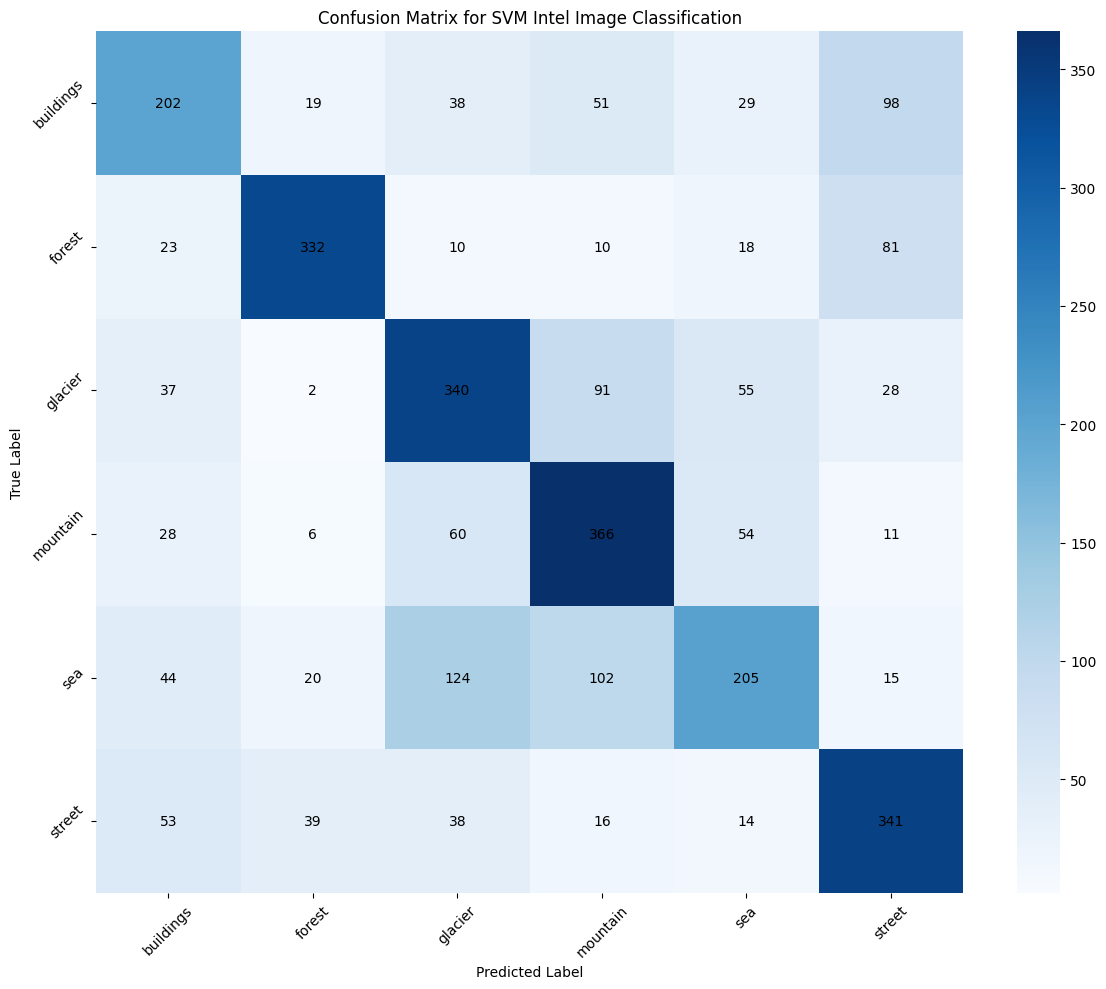

In [36]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
cm = confusion_matrix(y_test_trad, test_predictions)

plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(cm,          
            cmap='Blues',    
            xticklabels=class_names,
            yticklabels=class_names)  

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]),
                 ha='center', va='center',
                 color='black')

plt.title('Confusion Matrix for SVM Intel Image Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### SVM ROC Curve

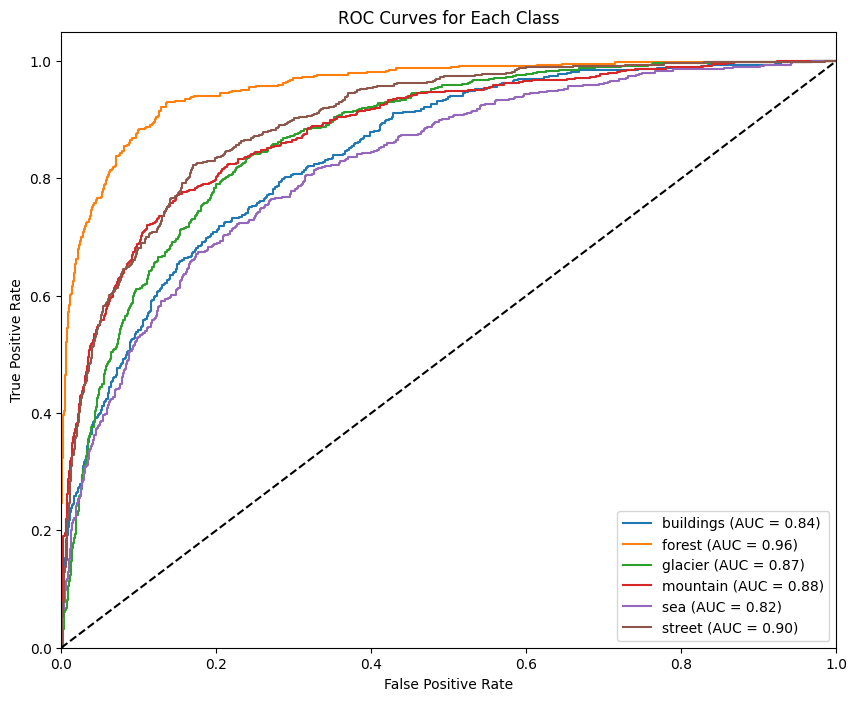

In [37]:
# Get probability predictions using scaled data
test_pred_proba = best_model.predict_proba(X_test_transformed_scaled)

def plot_roc_curves(y_test, y_pred_proba, class_names):
    # Get predictions with probabilities
    plt.figure(figsize=(10, 8))
    
    # Calculate ROC curve for each class
    for i in range(len(class_names)):
        # Create binary labels for current class
        y_bin = (y_test == i).astype(int)
        
        # Get probability scores for current class
        y_score = y_pred_proba[:, i]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_bin, y_score)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc="lower right")
    plt.show()

# Then plot ROC curves
plot_roc_curves(y_test_trad, test_pred_proba, class_names)

## Random Forest

In [38]:
# RandomForest Model
print("Training Random Forest Classifier...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train_ml)

# Evaluate Random Forest on validation set
rf_val_pred = rf.predict(X_val_ml)
print("\nRandom Forest Validation Results:")
print(classification_report(y_val_ml, rf_val_pred))
print(f"Validation Accuracy: {accuracy_score(y_val_ml, rf_val_pred):.3f}")

Training Random Forest Classifier...

Random Forest Validation Results:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       450
           1       0.72      0.83      0.77       472
           2       0.56      0.62      0.59       455
           3       0.57      0.63      0.60       515
           4       0.54      0.43      0.48       485
           5       0.61      0.63      0.62       430

    accuracy                           0.60      2807
   macro avg       0.59      0.60      0.59      2807
weighted avg       0.59      0.60      0.59      2807

Validation Accuracy: 0.599


## CNN & ResNet

In [39]:
# Convert labels to one-hot encoding for CNN/ResNet
num_classes = len(np.unique(train_labels))
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes)

# Create train/validation split for CNN/ResNet
X_train, X_val, y_train, y_val = train_test_split(
    train_images, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [40]:
# Define a CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the CNN model
cnn_model = create_cnn_model((150, 150, 3), num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN Model
cnn_history = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

# Evaluate the CNN Model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_images, test_labels_onehot)
print(f"CNN Model Accuracy: {cnn_accuracy * 100:.2f}%")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 212ms/step - accuracy: 0.4866 - loss: 1.3082 - val_accuracy: 0.6530 - val_loss: 0.8703
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.7194 - loss: 0.7367 - val_accuracy: 0.7823 - val_loss: 0.5819
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step - accuracy: 0.8071 - loss: 0.5271 - val_accuracy: 0.7848 - val_loss: 0.5641
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 209ms/step - accuracy: 0.8712 - loss: 0.3719 - val_accuracy: 0.8041 - val_loss: 0.5485
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 212ms/step - accuracy: 0.9084 - loss: 0.2548 - val_accuracy: 0.8051 - val_loss: 0.5954
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 209ms/step - accuracy: 0.9382 - loss: 0.1811 - val_accuracy: 0.8062 - val_loss: 0.6816
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.9625 - loss: 0.1067 - val_accuracy: 0.7948 - val_loss: 0.7977
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 75s 214ms/step - accuracy: 0.9760 - loss: 0

In [41]:
# ResNet50 Transfer Learning Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the ResNet model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet Model
resnet_history = resnet_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

# Evaluate the ResNet Model
resnet_loss, resnet_accuracy = resnet_model.evaluate(test_images, test_labels_onehot)
print(f"ResNet50 Model Accuracy: {resnet_accuracy * 100:.2f}%")

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 320s 896ms/step - accuracy: 0.3955 - loss: 3.2027 - val_accuracy: 0.5337 - val_loss: 1.0674
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 312s 889ms/step - accuracy: 0.6061 - loss: 0.9921 - val_accuracy: 0.6217 - val_loss: 0.9066
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 317s 904ms/step - accuracy: 0.6557 - loss: 0.8750 - val_accuracy: 0.6409 - val_loss: 0.8535
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 318s 907ms/step - accuracy: 0.6868 - loss: 0.8017 - val_accuracy: 0.5771 - val_loss: 1.0128
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 316s 901ms/step - accuracy: 0.7001 - loss: 0.7713 - val_accuracy: 0.7064 - val_loss: 0.7846
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 316s 899ms/step - accuracy: 0.7024 - loss: 0.7623 - val_accuracy: 0.7075 - val_loss: 0.7681
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 312s 890ms/step - accuracy: 0.7017 - loss: 0.7567 - val_accuracy: 0.6266 - val_loss: 0.8998
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 313s 892ms/step - accuracy: 0.6891 -

## Random Forest vs. SVM vs. CNN vs. ResNet Evaluation

In [42]:
# Summary of Model Performances
print("\nModel Performance Summary:")
print(f"Random Forest Model Accuracy: {accuracy_score(y_test_rf, y_pred_rf) * 100:.2f}%")
print(f"CNN Model Accuracy: {cnn_accuracy * 100:.2f}%")
print(f"ResNet50 Model Accuracy: {resnet_accuracy * 100:.2f}%")


Model Performance Summary:


NameError: name 'y_test_rf' is not defined